Ce notebook a pour objectif de présenter les différentes observations réalisées sur notre jeu de données. Il nous a donné des pistes d'exploration pour la consption de notre modèle d'apprentissage pour la prédiction de métier suivant le CV.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
%matplotlib inline

In [2]:
# Read our initial corpus (concatenation of the main project datasets)

df = pd.read_pickle("../../Project_outputs/pickled_files/corpus/initial_corpus.pkl")
df.head()

Id                                        description gender  categories
0   0   She is also a Ronald D. Asmus Policy Entrepre...      F   professor
1   1   He is a member of the AICPA and WICPA. Brent ...      M  accountant
2   2   Dr. Aster has held teaching and research posi...      M   professor
4   3   He runs a boutique design studio attending cl...      M   architect
5   4   He focuses on cloud security, identity and ac...      M   architect

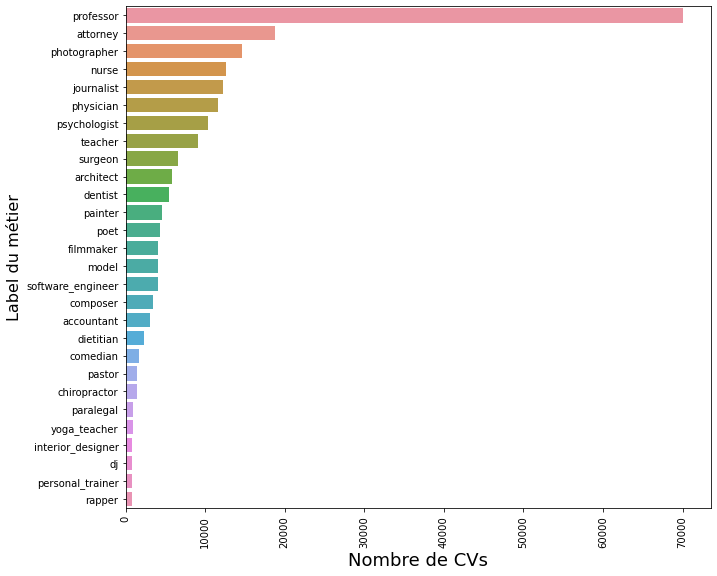

In [4]:
plt.figure(figsize=(10, 8))
plt.xticks(rotation=90)
sns_plot = sns.countplot(y="categories", data=df, order = df['categories'].value_counts().index)

plt.tight_layout()
plt.xlabel('Nombre de CVs', fontsize=18)
plt.ylabel('Label du métier', fontsize=16)
plt.show()
figure = sns_plot.get_figure() 
figure.savefig("../../Project_outputs/visualizations/number_of_resumes_by_cataegories.jpg", transparent=True)

On note que notre jeu de données est très déséquilibré. En effet, les métiers tels que 'personnal trainer', 'rapper', 'dj' ou encore 'paralegal' par exemple sont fortement minoritaires par rapport au métier de 'professor'. 

D'après cette visualisation, notre modèle serait plus susceptible de prédire correctement un métier de professeur qu'un métier de rappeur par exemple avec ce jeu de données.

Une approche pour traiter ce déséquilibre serait de tronquer nos jeux de données pour en avoir un où on aurait le même nombre de CV pour toutes les classes. Cependant cette approche nous serait préjudciable car à travers elle nous supprimerions potentiellement des données très pertinentes pour notre modèle. De fait, nous n'opterons pas pour cette approche.

In [6]:
df_cat_by_gender = pd.crosstab(index=df['categories'], columns=df['gender'])
df_cat_by_gender.sort_values(by='F', inplace=True, ascending=False)
df_cat_by_gender.head()

gender            F      M
categories                
professor     31424  38592
nurse         11493   1129
attorney       7106  11714
psychologist   6418   3973
journalist     6123   6172

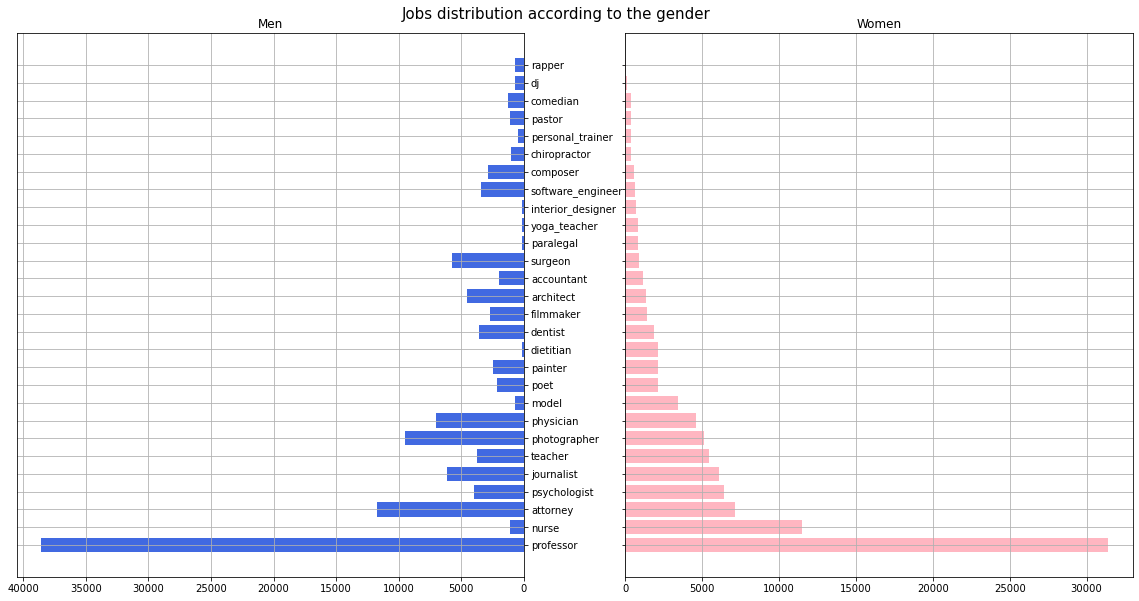

In [7]:
#define x and y limits
y = range(0, len(df_cat_by_gender))
x_men = df_cat_by_gender['M']
x_women = df_cat_by_gender['F']


#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(20, 10))


#specify background color and plot title
#fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.9,"Jobs distribution according to the gender", fontsize=15, ha='center')

#define male and female bars
axes[0].barh(y, x_men, align='center', color='royalblue')
axes[0].set(title='Men')
axes[1].barh(y, x_women, align='center', color='lightpink')
axes[1].set(title='Women')

#adjust grid parameters and specify labels for y-axis
axes[1].grid()
axes[0].set(yticks=y, yticklabels=df_cat_by_gender.index)
axes[0].invert_xaxis()
axes[0].yaxis.tick_right()
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=10)
axes[0].grid()

#display plot
#plt.tight_layout()
plt.show()
fig.savefig("../../Project_outputs/visualizations/Jobs distribution according to the gender.jpg", transparent=True, bbox_inches='tight')

In [14]:
cross = pd.crosstab(df['categories'], df['gender'], rownames=['categories'], colnames=['gender'])
cross.head()

gender           F      M
categories               
accountant    1129   1992
architect     1314   4527
attorney      7106  11714
chiropractor   391   1015
comedian       345   1294

In [15]:
import seaborn as sns

def plot_heatmap(cross_table, fmt='g'):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cross_table,
                annot=None,
                fmt=fmt,
                cmap='rocket_r',
                linewidths=.5,
                ax=ax)
    plt.show()

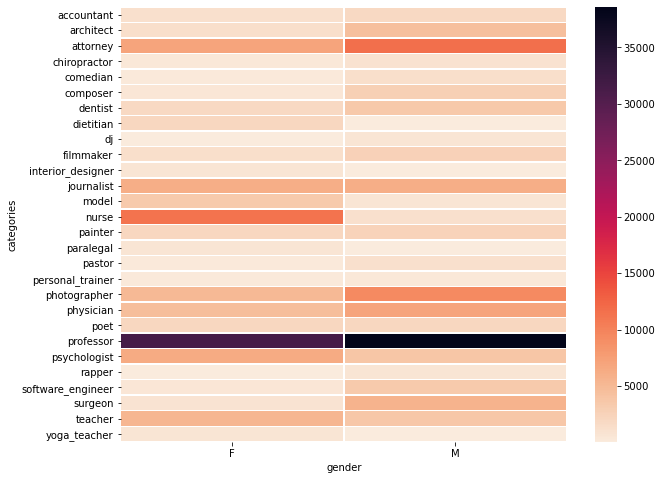

In [16]:
plot_heatmap(cross, fmt='.2%')

On note qu'en plus des déséquilibres existants entre les classes, nous notons aussi que dans notre jeu de données, il exsite des déséquilibres entre genre suivant les métiers. Tandis que les proportions entre homme et femme pour le métier de professeur sont à peu près égales,   pour les métiers comme infirmières, on a beaucoup plus de femmes que d'hommes. Il en est de même pour les métiers de psychologue, de journaliste, de diététitien. Par contre c'est l'inverse pour le métier de rappeur, ou d'avocat. 

In [17]:
def DI(tab):
    """
    Calcule le disparate impact ponctuel d'une table de contingence 
    Colonnes = Variable sensible
    Lignes = variable cible
    """
    tab_np = tab.to_numpy()
    print(tab_np)
    DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))
    return DI

In [23]:
from statistics import mean

def avgDis(cross):
    listDi = []
    index = cross.index
    for job in index:
        print("--------------------------------")
        print(f"job: {job}")
        actual = cross[index == job]
        others = cross[index != job]
        others_sum = cross.sum(axis=0).to_frame(name="others").T
        concat = pd.concat([others_sum, actual])
        print("corresponding crosstab:")
        di = DI(concat)
        print("")
        print(f"disparate impact of {job}: {di}")
        listDi.append(di)
    print(" ")
    print(listDi)
    return mean(listDi)

In [24]:
avgDi = avgDis(cross)

--------------------------------
job: accountant
corresponding crosstab:
[[ 99244 117953]
 [  1129   1992]]

disparate impact of accountant: 0.677282496328854
--------------------------------
job: architect
corresponding crosstab:
[[ 99244 117953]
 [  1314   4527]]

disparate impact of architect: 0.35353581883863394
--------------------------------
job: attorney
corresponding crosstab:
[[ 99244 117953]
 [  7106  11714]]

disparate impact of attorney: 0.7396256300952356
--------------------------------
job: chiropractor
corresponding crosstab:
[[ 99244 117953]
 [   391   1015]]

disparate impact of chiropractor: 0.4599694105158706
--------------------------------
job: comedian
corresponding crosstab:
[[ 99244 117953]
 [   345   1294]]

disparate impact of comedian: 0.31924265143961156
--------------------------------
job: composer
corresponding crosstab:
[[ 99244 117953]
 [   553   2842]]

disparate impact of composer: 0.23552256894303317
--------------------------------
job: dentist
co

In [25]:
print(f"Le disparate impact moyen associé à ce premier modèle de regression logistique est de {avgDi}.")

Le disparate impact moyen associé à ce premier modèle de regression logistique est de 2.3073546812730794.


Pour évaluer le biais que ce déséquilibre suivant le genre peut induire sur notre modèle, nous avons utilisé le disaparate impact. On note qu'en moyenne les femmes sont favorisées par rapport aux hommes. Cependant lorsqu'on regarde au cas par cas, ce n'est pas toujours le cas. 

En effet, lorsqu'on considère le métier de chirurgien, le disparate imapct est de 0,19. Ce qui signifie que les femmes pour ce métier sont fortement défavorisé par rapport aux hommes. 

Lorsqu'on considère le métier d'infirmière c'est tout l'inverse et lorsqu'on considère celui de professeur, le disparate impact tourne autour de 1. Cela implique que pour ce métier le biais est pratiquement inexistant.

In [ ]:
# data_fp = "../../Project_datasets/data.json"
# label_fp = "../../Project_datasets/label.csv"
# categories_fp = "../../Project_datasets/categories_string.csv"

# df_data = pd.read_json(data_fp)
# df_label = pd.read_csv(label_fp)
# df_categories = pd.read_csv(categories_fp)

# df_data.head()

# df_label.head()

# df_categories.head()

# df_categories.columns = ['label', 'label_code']
# df_categories.head()

# df_label_cat = df_label.join(df_categories.set_index('label_code')[['label']], on='Category')
# df_label_cat.head()

# df_data_label_cat = df_data.join(df_label_cat.set_index('Id')[['label']], on='Id')
# df_data_label_cat.rename(columns={"label": "categories"}, inplace=True)
# df_data_label_cat.head()

In [24]:
df_label_cat = df_label.join(df_categories.set_index('label_code')[['label']], on='Category')
df_label_cat.head()

Id  Category       label
0   0        19   professor
1   1         9  accountant
2   2        19   professor
3   3        24   architect
4   4        24   architect

In [29]:
df_data_label_cat = df_data.join(df_label_cat.set_index('Id')[['label']], on='Id')
df_data_label_cat.rename(columns={"label": "categories"}, inplace=True)
df_data_label_cat.head()

Id                                        description gender  categories
0   0   She is also a Ronald D. Asmus Policy Entrepre...      F   professor
1   1   He is a member of the AICPA and WICPA. Brent ...      M  accountant
2   2   Dr. Aster has held teaching and research posi...      M   professor
4   3   He runs a boutique design studio attending cl...      M   architect
5   4   He focuses on cloud security, identity and ac...      M   architect

In [31]:
print ("Displaying the distinct categories of resume -")
print (df_data_label_cat['categories'].unique())

Displaying the distinct categories of resume -
['professor' 'accountant' 'architect' 'psychologist' 'journalist'
 'teacher' 'nurse' 'attorney' 'software_engineer' 'painter' 'physician'
 'chiropractor' 'personal_trainer' 'photographer' 'surgeon' 'filmmaker'
 'dietitian' 'dj' 'model' 'composer' 'dentist' 'poet' 'comedian'
 'yoga_teacher' 'interior_designer' 'pastor' 'rapper' 'paralegal']


In [32]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category -")
print (df_data_label_cat['categories'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category -
professor            70016
attorney             18820
photographer         14646
nurse                12622
journalist           12295
physician            11607
psychologist         10391
teacher               9145
surgeon               6616
architect             5841
dentist               5450
painter               4621
poet                  4292
filmmaker             4124
model                 4115
software_engineer     4060
composer              3395
accountant            3121
dietitian             2288
comedian              1639
pastor                1497
chiropractor          1406
paralegal              967
yoga_teacher           944
interior_designer      858
dj                     831
personal_trainer       807
rapper                 783
Name: categories, dtype: int64


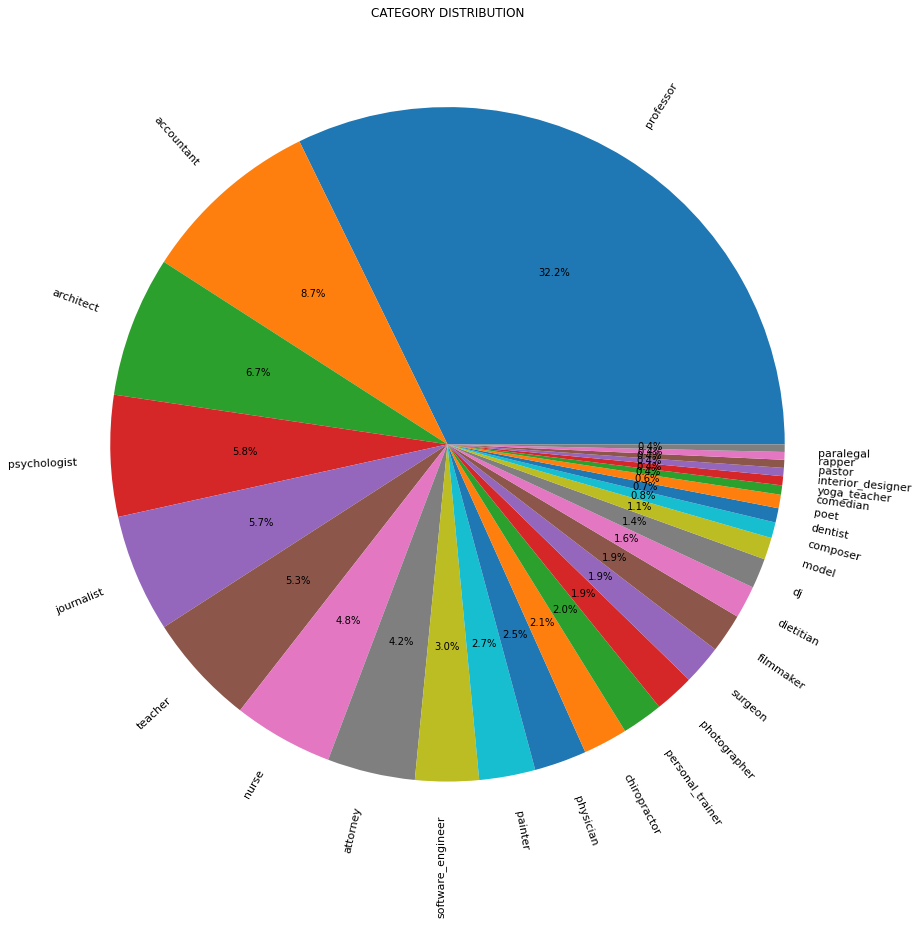

In [80]:
from matplotlib.gridspec import GridSpec
targetCounts = df_data_label_cat['categories'].value_counts()
targetLabels  = df_data_label_cat['categories'].unique()

# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
patches, texts, autotexts = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=False, rotatelabels=True)
texts = [_.set_fontsize(11) for _ in texts]
plt.tight_layout()
plt.show()

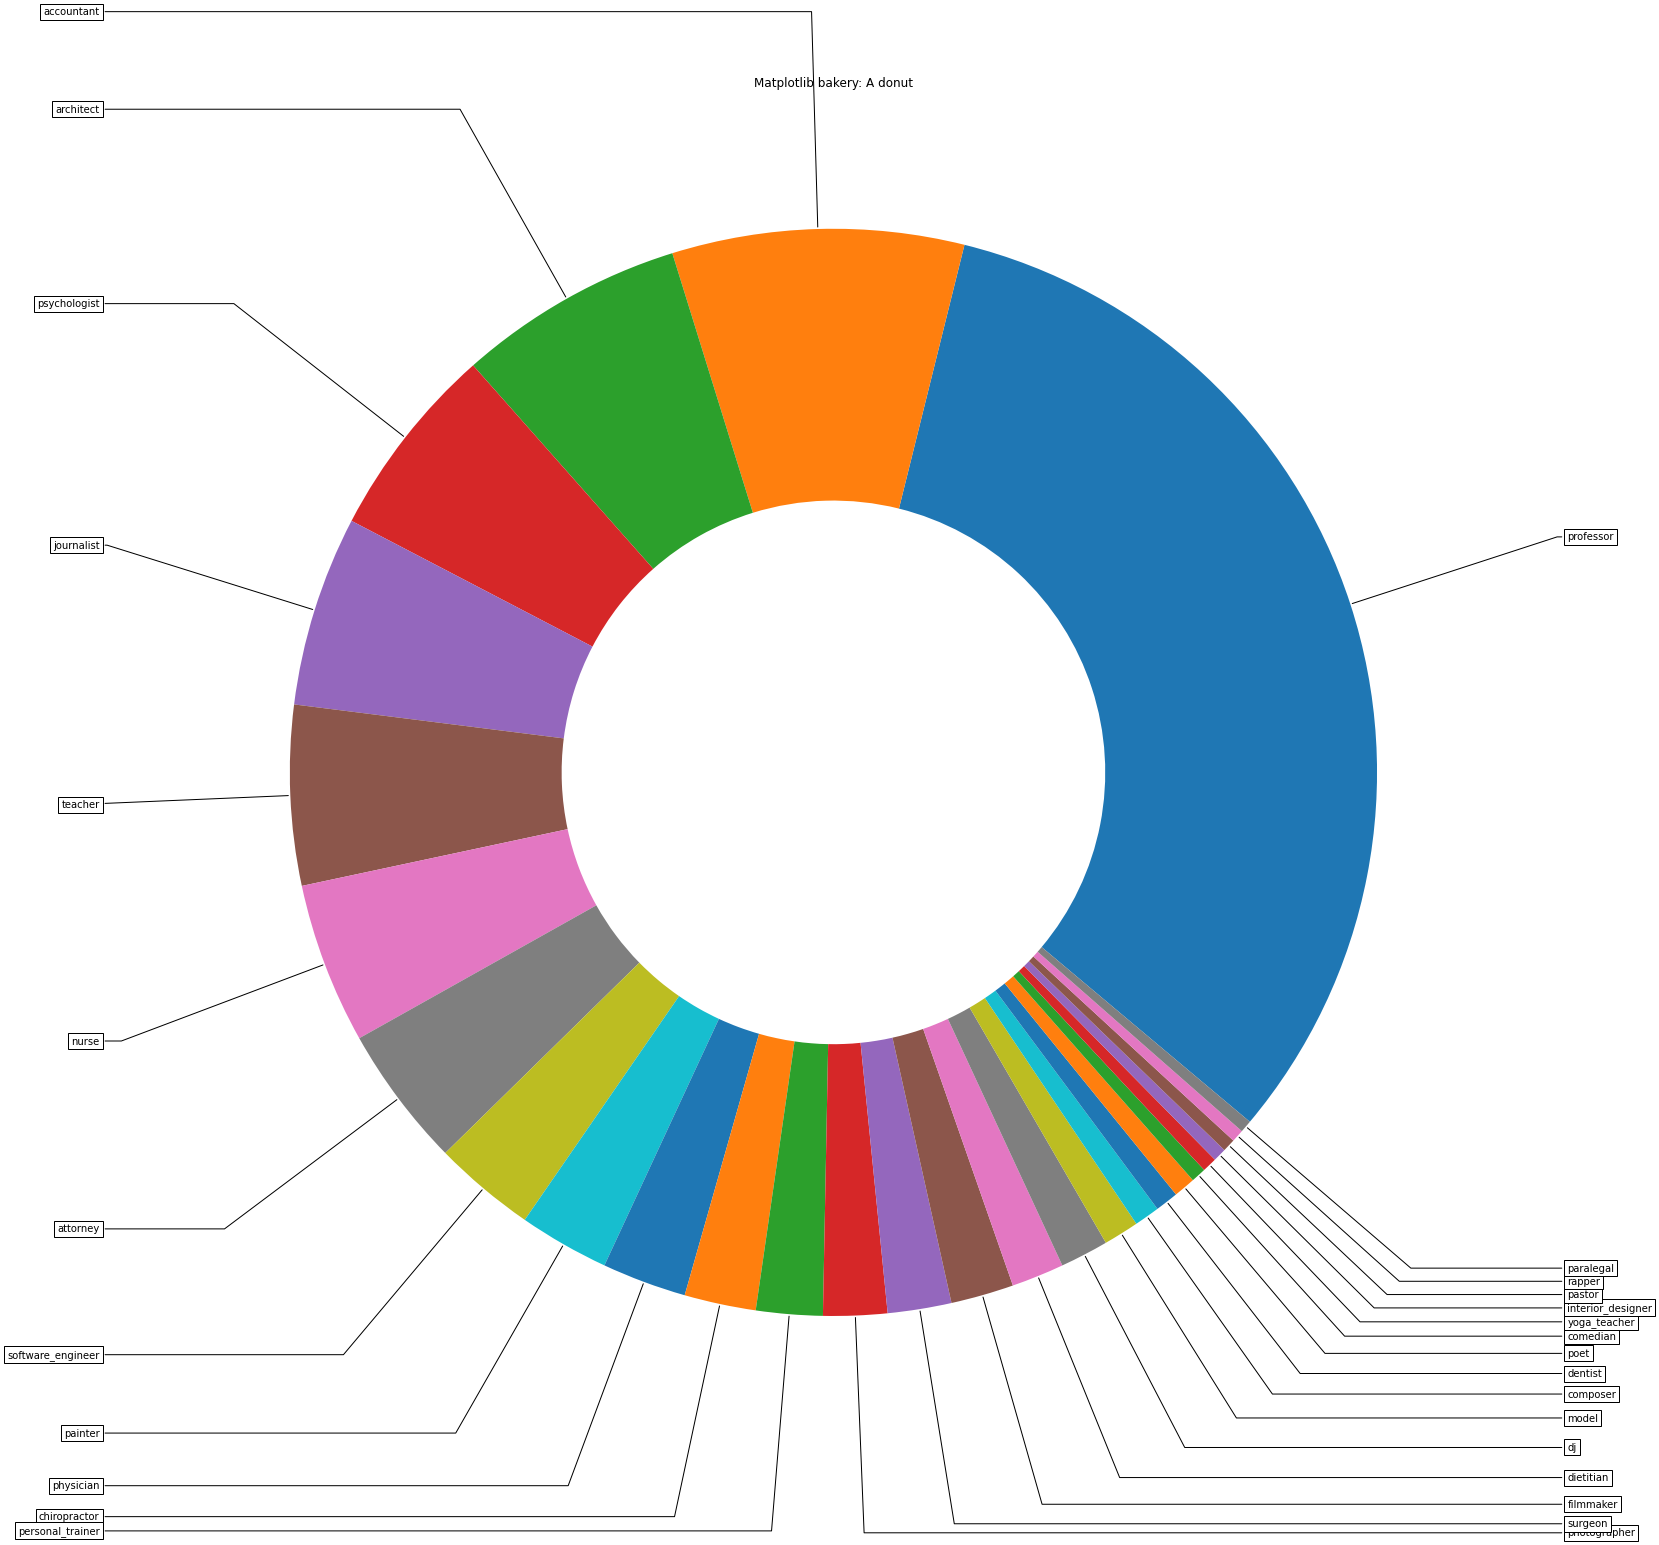

In [69]:
targetCounts = df_data_label_cat['categories'].value_counts()
targetLabels  = df_data_label_cat['categories'].unique()

fig, ax = plt.subplots(figsize=(25,25), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(targetCounts, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")


for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(targetLabels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

In [102]:
df_data_label_cat_fem = df_data_label_cat[df_data_label_cat.gender == 'F']
df_data_label_cat_fem
df_f = pd.DataFrame(df_data_label_cat_fem["categories"].value_counts())
df_f.reset_index(inplace=True)
df_f.columns = ["categories", "counts"]
df_f.head()
#df_["label"].sum()

categories  counts
0     professor   31424
1         nurse   11493
2      attorney    7106
3  psychologist    6418
4    journalist    6123

In [103]:
df_data_label_cat_male = df_data_label_cat[df_data_label_cat.gender == 'M']
df_data_label_cat_male
df_m = pd.DataFrame(df_data_label_cat_male["categories"].value_counts())
df_m.reset_index(inplace=True)
df_m.columns = ["categories", "counts"]
df_m.head()

categories  counts
0     professor   38592
1      attorney   11714
2  photographer    9517
3     physician    7026
4    journalist    6172

In [107]:
df_joined = df_f.merge(df_m, on="categories", how="left")
df_joined.rename(columns={"counts_x": "women", "counts_y":"men"}, inplace=True)
df_joined.head()

categories  women    men
0     professor  31424  38592
1         nurse  11493   1129
2      attorney   7106  11714
3  psychologist   6418   3973
4    journalist   6123   6172

In [146]:
df_f_perc = pd.DataFrame(df_data_label_cat_fem['categories'].value_counts(normalize=True))
df_m_perc = pd.DataFrame(df_data_label_cat_male['categories'].value_counts(normalize=True))
df_f_perc.reset_index(inplace=True)
df_m_perc.reset_index(inplace=True)
df_f_perc.columns = ['categories', 'percentage']
df_m_perc.columns = ['categories','percentage']
join_df = df_f_perc.merge(df_m_perc, on='categories', how='left')
join_df.rename(columns={"percentage_x": "women", "percentage_y":"men"}, inplace=True)
join_df.head()

categories     women       men
0     professor  0.316634  0.327181
1         nurse  0.115805  0.009572
2      attorney  0.071601  0.099311
3  psychologist  0.064669  0.033683
4    journalist  0.061696  0.052326

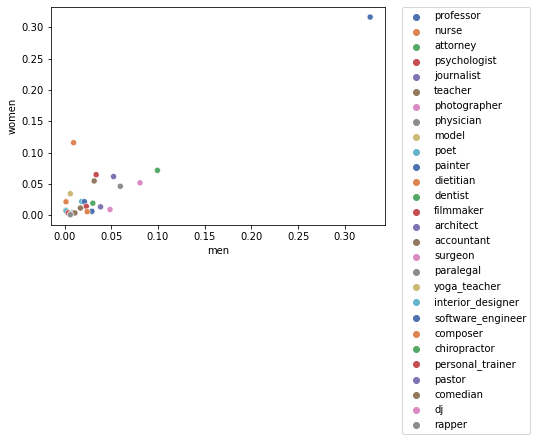

In [152]:
sns.scatterplot(y=join_df.women, x=join_df.men, hue=join_df.categories,
                palette="deep",legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
Item_weight = sales["Item_weight"]
Item_weight = pd.to_numeric(Item_weight, errors="coerce")
sales["Item_weight"] = Item_weight

In [224]:
df_fem_val_counts = pd.DataFrame(df_data_label_cat_fem['label'].value_counts(normalize=True))
df_mal_val_counts = pd.DataFrame(df_data_label_cat_male['label'].value_counts(normalize=True))
df_fem_val_counts = df_fem_val_counts.reset_index()
df_mal_val_counts = df_mal_val_counts.reset_index()
df_fem_val_counts.columns = ['categories', 'percentage']
df_mal_val_counts.columns = ['categories','percentage']
join_df = df_fem_val_counts.merge(df_mal_val_counts, on='categories', how='left')
join_df

#percentage_x = women
#percentage_y = men


#df_gender_val_counts = df_fem_val_counts.join(df_mal_val_counts.set_index('categories')[['percentage']], on='categories')
#df_gender_val_counts
#df_gender_val_counts = df_fem_val_counts.set_index('categories').join(df_mal_val_counts.set_index('categories'))
#df_fem_val_counts = df_fem_val_counts.T
#df_fem_val_counts

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [173]:
df_fem_val_counts

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [174]:
df_mal_val_counts

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<Figure size 1000x1000 with 0 Axes>

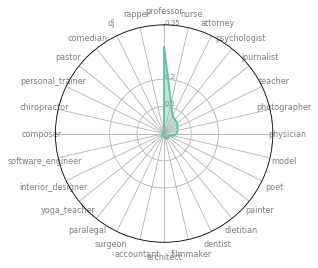

<Figure size 1000x1000 with 0 Axes>

In [135]:
#my_dpi=1
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
categories = list(df_fem_val_counts)
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True, )
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.4], ["0.1","0.2","0.35"], color="grey", size=7)
plt.ylim(0,0.4)
values=df_fem_val_counts.loc['percentage'].values.flatten().tolist()
values += values[:1]
values
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_fem_val_counts.index))
ax.plot(angles, values, color=my_palette(0), linewidth=2, linestyle='solid')
ax.fill(angles, values, color=my_palette(0), alpha=0.4)
my_dpi=1000
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

<Figure size 720x720 with 0 Axes>

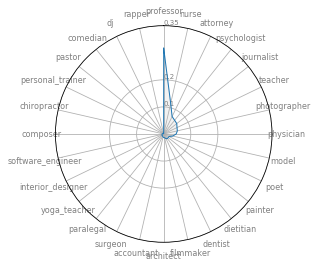

<Figure size 720x720 with 0 Axes>

In [155]:
categories = list(df_fem_val_counts)
N = len(categories)

values=df_fem_val_counts.loc['percentage'].values.flatten().tolist()
values += values[:1]
values

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles

#f = plt.figure()
#print(f)
#figsize=(2,2)
#dpi = 216
#ax = plt.subplot(111, polar=True)
#ax = plt.subplot(figsize=(6,6), subplot_kw=dict(projection='polar'))
ax = plt.subplot2grid((2,3), (0,1), rowspan=2, colspan=2, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories, color='grey', size=8)

ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.4], ["0.1","0.2","0.35"], color="grey", size=7)
plt.ylim(0,0.4)

ax.plot(angles, values, linewidth=1, linestyle='solid')

ax.fill(angles, values,  color="grey", alpha=0.1)

plt.figure(figsize=(10,10))

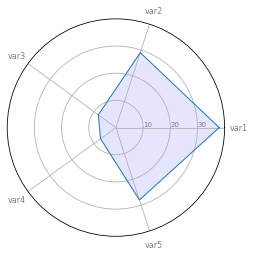

In [156]:
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

In [70]:
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
len(df.index)
df


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [235]:
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(df, row, title, color):
 
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.4], ["0.1","0.2","0.35"], color="grey", size=7)
    plt.ylim(0,0.4)

    # Ind1
    values=df.loc[row].drop('categories').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

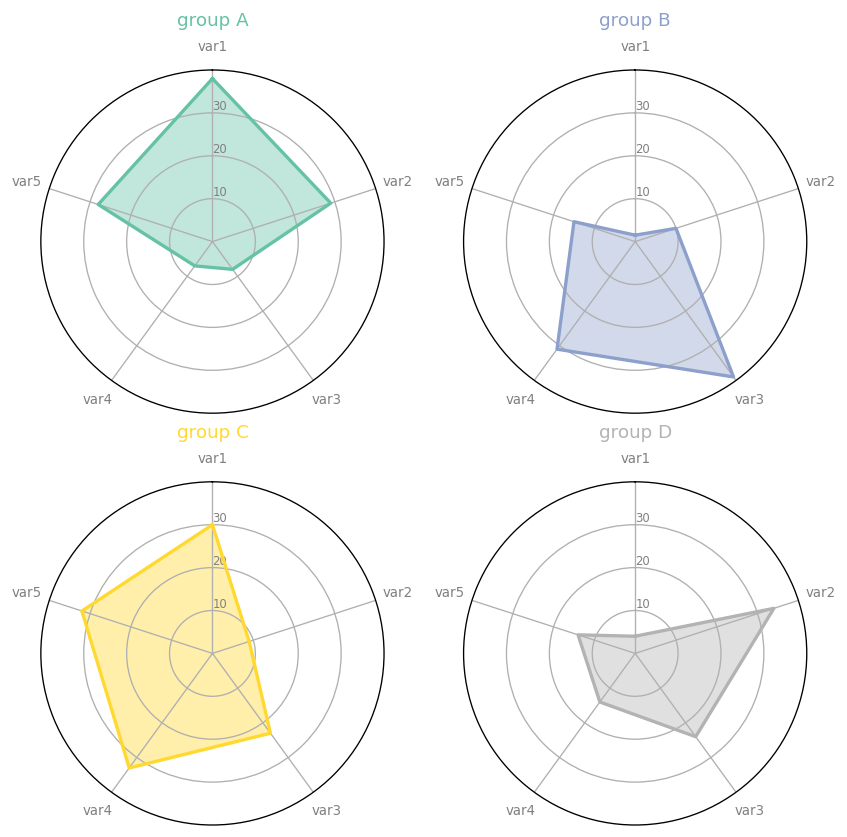

In [196]:
# Libraries
# import matplotlib.pyplot as plt
# import pandas as pd
# from math import pi
 
# # Set data
# df = pd.DataFrame({
# 'group': ['A','B','C','D'],
# 'var1': [38, 1.5, 30, 4],
# 'var2': [29, 10, 9, 34],
# 'var3': [8, 39, 23, 24],
# 'var4': [7, 31, 33, 14],
# 'var5': [28, 15, 32, 14]
# })
# # ------- PART 2: Apply to all individuals
# # initialize the figure
# my_dpi=120
# plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# # Create a color palette:
# my_palette = plt.cm.get_cmap("Set2", len(df.index))
    
# # Loop to plot
# for row in range(0, len(df.index)):
#     make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))

In [239]:
#df_join = join_df.set_index("categories").T
df_join = join_df.T.reset_index()
header_row = 0
df_join.columns = df_join.iloc[header_row]
df_join = df_join.drop(header_row)
df_join = df_join.reset_index(drop=True)
for row in range(0, len(df_join.index)):
    print(row)
#df_join["categories"][0]
#list(df_join)[1:]
join_df

0
1


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

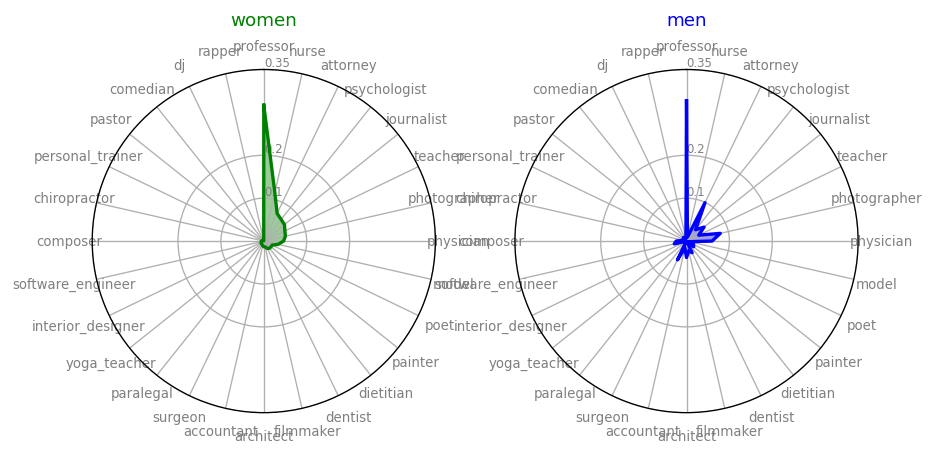

In [238]:
# initialize the figure
my_dpi=120
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_join.index))

make_spider(df=df_join, row=0, title="women", color="green")
make_spider(df=df_join, row=1, title="men", color="blue")

    